## PBL(1): Individual Project Work

1. https://agtechresearch.pythonanywhere.com/ 에 접속하여 회원가입해 주세요. (비밀번호는 단순하게 만드는 것을 권장. 예: 1234)
2. `username` 에 이메일 형식의 아이디를 기입해 주세요.
3. `password` 에 비밀번호를 기입해 주세요.

In [1]:
project = "housingprice"  # 수정하지 마세요
username = "g4312@naver.com"  # 회원가입 시 사용한 이메일아이디 (예시. abc@hello.com)
password = "1234"  # 비밀번호

리더보드 제출을 위한 기본 설정: 아래 코드를 실행해주세요.


In [2]:
import os
import urllib.request

if not os.path.exists("competition.py"):
    url = "https://raw.githubusercontent.com/agtechresearch/LectureAlgorithm/main/competition/competition.py"
    filename = "competition.py"
    urllib.request.urlretrieve(url, filename)

아래 코드를 실행하여 데이터를 다운로드 받습니다: 3개의 csv 파일이 data 폴더에 다운로드됨

 * dataset.csv: 과거 주택매매 데이터 -> 학습에 사용할 데이터셋
 * problem.csv: 현재 A사가 매매를 고려하고 있는 130건의 주택정보 -> ML 모델에 의하여 예측을 수행하여야 할 데이터셋
 * submission.csv: 리더보드 서버 제출을 위한 파일 형식


In [3]:
import competition

# 파일 다운로드
competition.download_competition_files(project)

100%|██████████| 141k/141k [00:00<00:00, 359kiB/s] 


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 경고 무시
warnings.filterwarnings("ignore")

# Data 경로 설정
DATA_DIR = "data"

In [25]:
# 학습에 사용할 과거 주택매매 data set 로드 (dataset.csv)
dataset = pd.read_csv(os.path.join(DATA_DIR, "dataset.csv"))

# problem set 로드 (problem.csv)
problemset = pd.read_csv(os.path.join(DATA_DIR, "problem.csv"))

In [26]:
# # 결측치가 있다면 GarageType은 NO Garage로, GarageYrBlt의 값은 0으로 대체
dataset["GarageType"].fillna("No Garage", inplace=True)
dataset["GarageYrBlt"].fillna(0, inplace=True)

dataset.isnull().sum()


Id              0
LotArea         0
Street          0
LotConfig       0
OverallQual     0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
TotalBsmtSF     0
1stFlrSF        0
2ndFlrSF        0
GrLivArea       0
FullBath        0
HalfBath        0
BedroomAbvGr    0
KitchenAbvGr    0
TotRmsAbvGrd    0
Fireplaces      0
GarageType      0
GarageYrBlt     0
GarageCars      0
GarageArea      0
YrSold          0
SalePrice       0
dtype: int64

In [27]:
# dataset을 train set과 test set으로 나누기, y는 SalePrice
from sklearn.model_selection import train_test_split
y = dataset["SalePrice"]
X = dataset.drop("SalePrice", axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


(1072, 23) (268, 23) (1072,) (268,)


In [28]:
# 범주형 변수들을 모두 one-hot encoding하는데 x_train에 하는걸 그대로 x_val에도 적용
# x_train = pd.get_dummies(x_train)
# x_val = pd.get_dummies(x_val)


In [29]:
# Random over-sampling 적용




오버샘플링을 하려고 했으나 소수 클래스에 대해 적은 수의 샘플이 있어서 SMOTE 또는 ADASYN이 적절한 이웃을 찾지 못하고 있다
그럼에도 불구하고 오버샘플링은 중요해보인다. 그렇다면 개수가 적은 샘플들은 다른 값으로 치환해 버릴까?

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 수치형 변수와 범주형 변수를 구분
numeric_features = x_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = x_train.select_dtypes(include=['object']).columns

# 전처리 파이프라인 정의


categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Pipeline 정의
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# train 데이터셋에 Pipeline 적용
x_train_preprocessed = pipeline.fit_transform(x_train)

# val 및 test 데이터셋에 Pipeline 적용
x_test_preprocessed = pipeline.transform(x_test)
x_problem_preprocessed = pipeline.transform(problemset)


In [31]:
# lightgbm 모델 학습
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
lgb = lgb.LGBMRegressor()
lgb.fit(x_train_preprocessed, y_train)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2012
[LightGBM] [Info] Number of data points in the train set: 1072, number of used features: 28
[LightGBM] [Info] Start training from score 179921.842351


LGBMRegressor()

In [32]:
from sklearn.metrics import mean_squared_error

train_pred = lgb.predict(x_train_preprocessed)
test_pred = lgb.predict(x_val_preprocessed)

print("Train RMSE :", mean_squared_error(y_train, train_pred) ** 0.5)
print("Test RMSE :", mean_squared_error(y_test, test_pred) ** 0.5)

Train RMSE : 14638.653375486965
Test RMSE : 34697.09065274077


In [33]:
problem_pred = lgb.predict(x_problem_preprocessed)

In [34]:
# 리더보드 서버 제출을 위한 파일 생성
submission = pd.read_csv(os.path.join(DATA_DIR, "submission.csv"))
submission["SalePrice"] = problem_pred

# 예측 결과 화면에 출력 후 제출
display(submission)
competition.submit(project, username, password, submission)

,Id,SalePrice
0,1341,128584.143230
1,1342,137901.250390
2,1343,151623.399137
3,1344,141306.077293
4,1345,103820.356494
...,...,...
125,1466,299769.883072
126,1467,192158.110242
127,1468,76698.618850
128,1469,100059.603068


아이디:  g4312@naver.com
파일명:  submissions\20240514-115601-submission.csv
[제출에 성공하였습니다]
제출 결과: 34808.40467911388


Text(0.5, 1.0, 'LightGBM Features (avg over folds)')

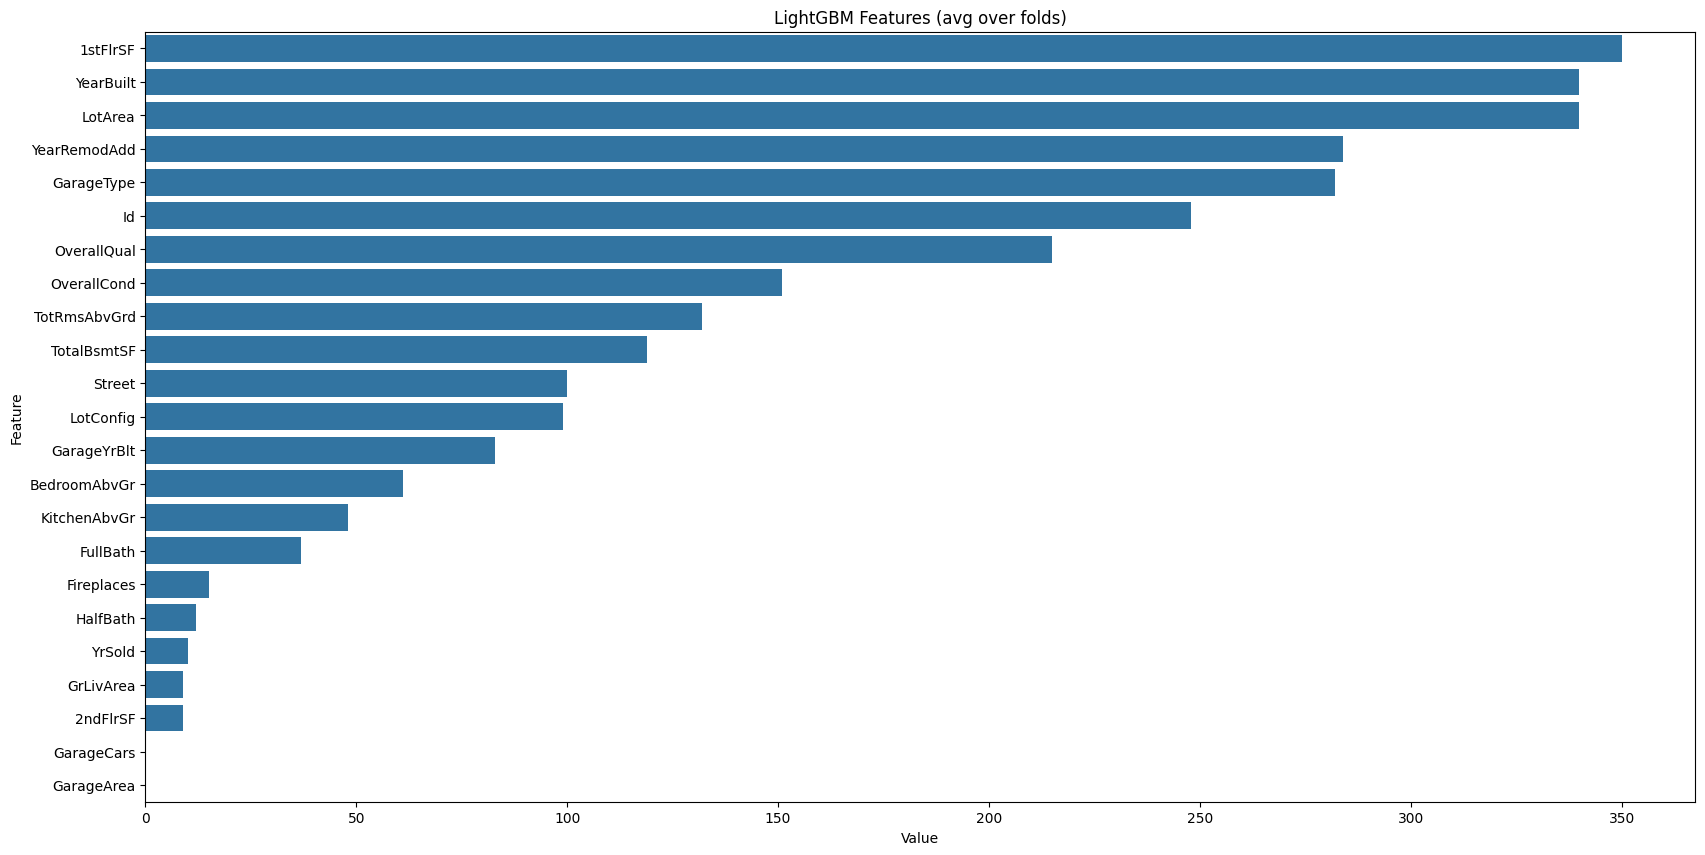

In [35]:
# LightGBM 모델의 feature importance 시각화
feature_imp = pd.DataFrame(sorted(zip(lgb.feature_importances_, x_train.columns)), columns=['Value', 'Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
